## Действительно ли помогают неразмеченные данные?

Частичное обучение (semi-supervised learning) предлагает методы работы с выборками, в которых лишь для части объектов известны ответы. В статьях утверждается, что добавление неразмеченных данных позволяет повысить качество работы — давайте выясним, так ли это!

Наверное, проще всего добыть неразмеченные примеры, если речь идёт о работе с текстами или изображениями. Остановимся на текстах.

Будем работать с данными из соревнования Predict closed questions on Stack Overflow: https://www.kaggle.com/c/predict-closed-questions-on-stack-overflow/data

Нас будет интересовать файл train-sample.csv — загрузите его. Будем решать бинарную задачу: отнесём объект к классу 1, если `OpenStatus == 'open'`, и к классу 0 иначе.

**Задание 1. (5 баллов)**

Загрузите данные и подготовьте выборку. В качестве признаков возьмите TF-IDF по BodyMarkdown с `min_df=10`; про целевую переменную написано выше. Выделите тестовую выборку из 5000 объектов.

In [1]:
import pandas as pd

data = pd.read_csv("train-sample.csv")
data["OpenStatus"] = data["OpenStatus"].apply(lambda x: 1 if x == "open" else 0)

In [2]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(min_df=10)
X = vectorizer.fit_transform(data["BodyMarkdown"].fillna(""))

y = data["OpenStatus"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (135272, 23179)
Test shape: (5000, 23179)


Нас будут интересовать качество (AUC-ROC) в четырёх следующих постановках:
1. Модель обучается только на размеченных данных.
2. Модель обучается на размеченных и неразмеченных данных, причём неразмеченная часть не пересекается с тестовой выборкой.
3. Модель обучается на размеченных и неразмеченных данных, причём неразмеченная часть совпадает с тестовой выборкой.
4. Модель обучается на размеченных и неразмеченных данных, причём неразмеченная часть включает в себя тестовую выборку.

**Задание 1. (5 баллов)**

Проведите эксперименты и сделайте выводы для любого из методов пакета `sklearn.semi_supervised` и для логистической регрессии

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import roc_auc_score

X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

y_train_unlabeled1 = np.copy(y_train_unlabeled)
y_train_unlabeled[:] = -1

In [4]:
# 1. Model on labeled data
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_labeled, y_train_labeled)
y_pred_lr = clf_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_lr)

print(f"AUC-ROC (labeled data): {auc_lr:.4f}")

AUC-ROC (labeled data): 0.8093


In [5]:
from scipy.sparse import vstack

# 2. Labeled + unlabeled data (not overlapping with the test set)
clf_semi_1 = SelfTrainingClassifier(LogisticRegression(max_iter=1000))
clf_semi_1.fit(vstack([X_train_labeled, X_train_unlabeled]), np.concatenate((y_train_labeled, y_train_unlabeled)))
y_pred_semi_1 = clf_semi_1.predict_proba(X_test)[:, 1]
auc_semi_1 = roc_auc_score(y_test, y_pred_semi_1)

print(f"AUC-ROC (labeled + unlabeled, not overlapping with the test set): {auc_semi_1:.4f}")

AUC-ROC (labeled + unlabeled, not overlapping with the test set): 0.8094


In [6]:
from scipy.sparse import vstack

# 3. Labeled + unlabeled data (overlapping with the test set)
clf_semi_2 = SelfTrainingClassifier(LogisticRegression(max_iter=1000))
clf_semi_2.fit(vstack([X_train_labeled, X_test]), np.concatenate([y_train_labeled, np.full(X_test.shape[0], -1)]))
y_pred_semi_2 = clf_semi_2.predict_proba(X_test)[:, 1]
auc_semi_2 = roc_auc_score(y_test, y_pred_semi_2)

print(f"AUC-ROC (labeled + unlabeled, overlapping with the test set): {auc_semi_2:.4f}")

AUC-ROC (labeled + unlabeled, overlapping with the test set): 0.8095


In [7]:
from scipy.sparse import vstack

# 4. Labeled + unlabeled data (including the test set)x
clf_semi_3 = SelfTrainingClassifier(LogisticRegression(max_iter=1000))
clf_semi_3.fit(vstack([X_train, X_test]), np.concatenate([y_train, np.full(X_test.shape[0], -1)]))
y_pred_semi_3 = clf_semi_3.predict_proba(X_test)[:, 1]
auc_semi_3 = roc_auc_score(y_test, y_pred_semi_3)

print(f"AUC-ROC (labeled + unlabeled, including the test set): {auc_semi_3:.4f}")

AUC-ROC (labeled + unlabeled, including the test set): 0.8103


**Вывод**: точность действительно немного, но повысилась

### Self-train

Обучаем на размеченной части, предсказываем неразмеченную, потом обучаем на всех, и предсказываем неразмеченную, повторяем пока не сойдёмся в предскзааниях неразмеченной части

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from scipy.sparse import vstack
from IPython.display import clear_output

model = LogisticRegression()

model.fit(X_train_labeled, y_train_labeled)
    
y_pred = model.predict(X_train_unlabeled)
prev_y_pred = y_pred.copy()

accuracies = []
losses = []

for i in range(1000):
    print(f"Epoch #{i+1}")
    
    X_combined = vstack((X_train_labeled, X_train_unlabeled))
    y_combined = np.concatenate((y_train_labeled, y_pred))
    
    model.fit(X_combined, y_combined)
    y_pred = model.predict(X_train_unlabeled)
    
    if np.array_equal(prev_y_pred, y_pred):
        clear_output()
        print(f"Converged after {i+1} epochs!")
        break
    
    prev_y_pred = y_pred.copy()
    
    accuracy = accuracy_score(y_train_unlabeled1, y_pred) if y_train_unlabeled1 is not None else 0
    loss = log_loss(y_train_unlabeled1, model.predict_proba(X_train_unlabeled)) if y_train_unlabeled1 is not None else 0
    
    accuracies.append(accuracy)
    losses.append(loss)

accuracy_pred = accuracy_score(y_test, model.predict(X_test))
print(f"Test accuracy: {accuracy_pred}")

Converged after 23 epochs!
Test accuracy: 0.729


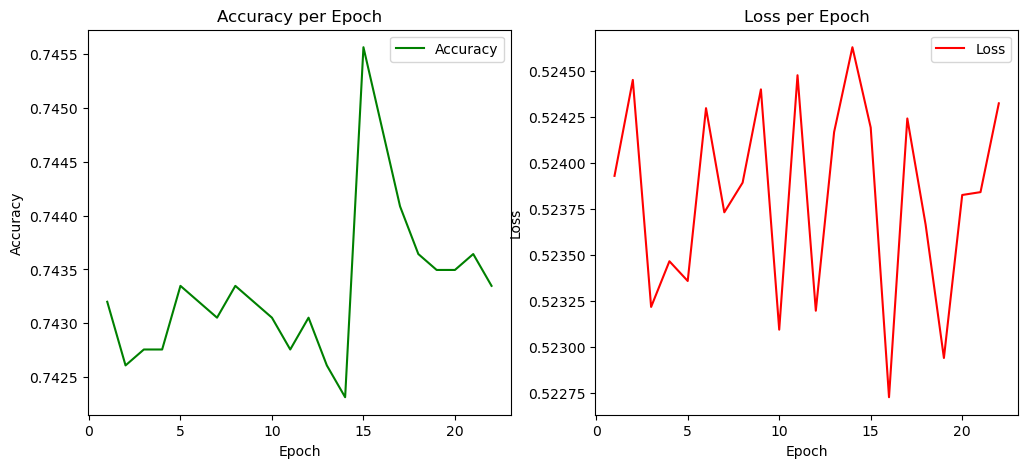

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracies) + 1), accuracies, 'g-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# График Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(losses) + 1), losses, 'r-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.show()